In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

C:\Users\anhqu\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
from graphviz import Digraph

In [4]:
df = pd.read_csv("C:/Users/anhqu/OneDrive/Desktop/QAs/QA_dataset/churn.csv")

## Data Sample

In [5]:
df.head()

,ID,LONGDIST,International,LOCAL,DROPPED,PAY_MTHD,LocalBillType,LongDistanceBillType,AGE,SEX,STATUS,CHILDREN,Est_Income,Car_Owner,CHURNED
0,0,5.24640,7.51510,86.32780,0,CH,FreeLocal,Standard,57,F,M,2,27535.3,Y,Vol
1,3,0.00000,0.00000,3.94229,0,CC,Budget,Intnl_discount,50,F,S,2,64632.3,N,InVol
2,4,5.55564,0.00000,9.36347,1,CC,Budget,Intnl_discount,68,F,M,2,81000.9,N,Vol
3,8,14.01930,5.68043,29.80650,0,CC,Budget,Standard,34,M,S,0,87467.1,Y,Current
4,10,13.66400,2.95642,32.63810,0,CC,FreeLocal,Intnl_discount,60,M,M,2,83220.6,N,Vol


## Data Type

In [6]:
for i in range(1, len(df.columns)):
    print(df.columns[i], type(df.iloc[0,i]))

LONGDIST <class 'numpy.float64'>
International <class 'numpy.float64'>
LOCAL <class 'numpy.float64'>
DROPPED <class 'numpy.int64'>
PAY_MTHD <class 'str'>
LocalBillType <class 'str'>
LongDistanceBillType <class 'str'>
AGE <class 'numpy.int64'>
SEX <class 'str'>
STATUS <class 'str'>
CHILDREN <class 'numpy.int64'>
Est_Income <class 'numpy.float64'>
Car_Owner <class 'str'>
CHURNED <class 'str'>


## Convert Categorical Variables to Numerical

##### Bucket Age 

In [7]:
# Also convert the cut to string type
df['AGE'] = pd.cut(x=df['AGE'], bins=[0, 20, 29, 39, 49, 59, 69, 79, 89, 99]).astype(str)

###### Create columns for the new numerical variables

In [8]:
# All categorical columns
cat_var = [df.columns[i] for i in range(len(df.columns)) if type(df.iloc[0, i]) == str]
print(cat_var)

['PAY_MTHD', 'LocalBillType', 'LongDistanceBillType', 'AGE', 'SEX', 'STATUS', 'Car_Owner', 'CHURNED']


In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
number = LabelEncoder()

for key, value in enumerate(cat_var):
    df[value + str('_num')] = number.fit_transform(df[value].astype('str'))

In [84]:
input_cols = [df.columns[i] for i in range(len(df.columns)) 
              if isinstance(df.iloc[0,i], np.float64) == True
              or isinstance(df.iloc[0,i], np.int32) == True
              or isinstance(df.iloc[0,i], np.int64) == True]

# Exclude ID and Churned column
input_cols = input_cols[1:-1]

print('Total Number of Possible Inputs: ' + str(len(input_cols)))
print('\n')
print(input_cols)

Total Number of Possible Inputs: 13


['LONGDIST', 'International', 'LOCAL', 'DROPPED', 'CHILDREN', 'Est_Income', 'PAY_MTHD_num', 'LocalBillType_num', 'LongDistanceBillType_num', 'AGE_num', 'SEX_num', 'STATUS_num', 'Car_Owner_num']


### Patrition Training and Testing Data

In [153]:
X = df[input_cols]
y = df.CHURNED_num

In [154]:
# 70% training and 30% test
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

In [155]:
# https://www.datacamp.com/community/tutorials/decision-tree-classification-python

# <font color = tomato> Decision Tree Classification

### Input all Variables into the Model

In [156]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

### Model result

In [157]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.75


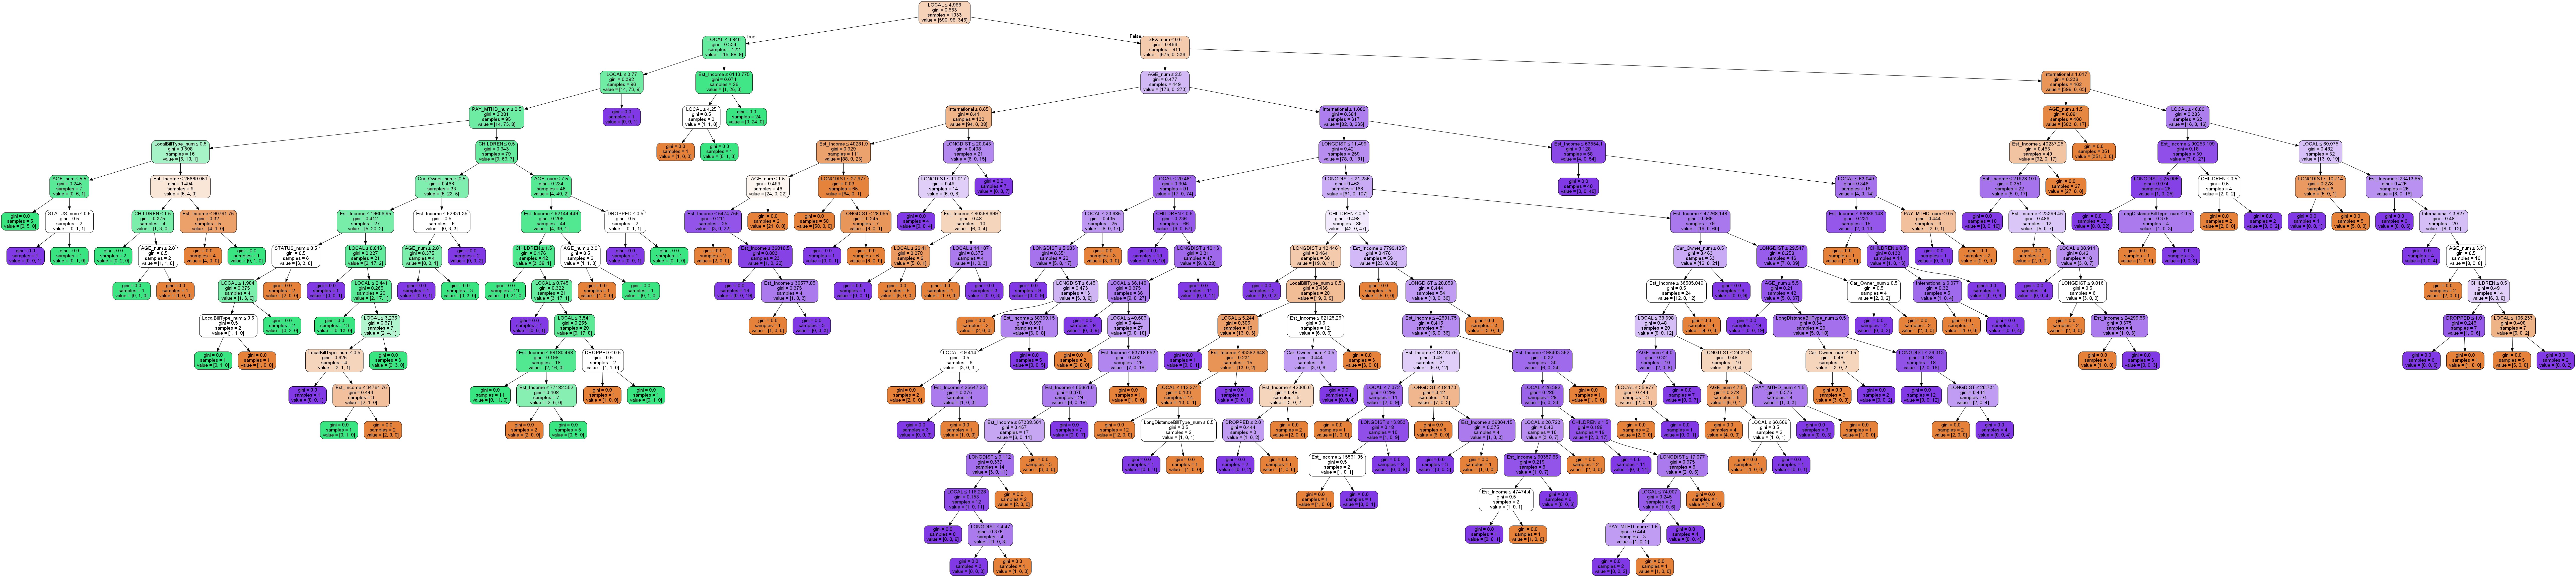

In [158]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = input_cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Optimize the Model

As seen above, the model is overfitted due to high number of input variables plus there is no constraint on the maximum depth of the tree

We will leverage Python loop to find the optimal configuration of the model

There are 3 inputs that we can set parameters:
- test_size: ranging from 0.1 to 0.7
- criterion: gini or entropy
- max_depth: ranging from 1 to 10

The only paramter that is difficult to loop is the input variables. This is best selected by our discretion. 

As the result, I'll create a function so that the 3 parameters could be automatically tested while what's left for us to decide is which variables to use

In [195]:
def decision_tree_opt(input_cols):
    input_criterion = ['gini', 'entropy']
    input_max_depth = range(1,10)
    test_size = [.1,.2,.3,.4,.5,.6,.7]
    
    X = df[input_cols]
    y = df.CHURNED_num

    result_list = []

    # Loop to insert input combination into the model
    for u in test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=u, random_state=1) 
        for i in input_critertion:
            for o in input_max_depth: 
                # Create Decision Tree classifer object
                clf = DecisionTreeClassifier(criterion=i, max_depth=o)

                # Train Decision Tree Classifer
                clf = clf.fit(X_train,y_train)

                #Predict the response for test dataset
                y_pred = clf.predict(X_test)

                accuracy_result = metrics.accuracy_score(y_test, y_pred)
                result_list.append((u, i, o, round(accuracy_result,3)))

    result_list = pd.DataFrame(result_list, columns=['test_size', 'criterion', 'max_depth', 'accuracy'])
    # print(result_list)

    optimal_config = result_list.iloc[result_list['accuracy'].idxmax()].to_list()
    print('Model Optimal Configuration: ')
    print('test_size, criterion, maximum tree depth, accurary')
    return optimal_config

In [196]:
decision_tree_opt(input_cols)

Model Optimal Configuration: 
test_size, criterion, maximum tree depth, accurary


[0.2, 'gini', 4, 0.872]

### Decision Tree Graph

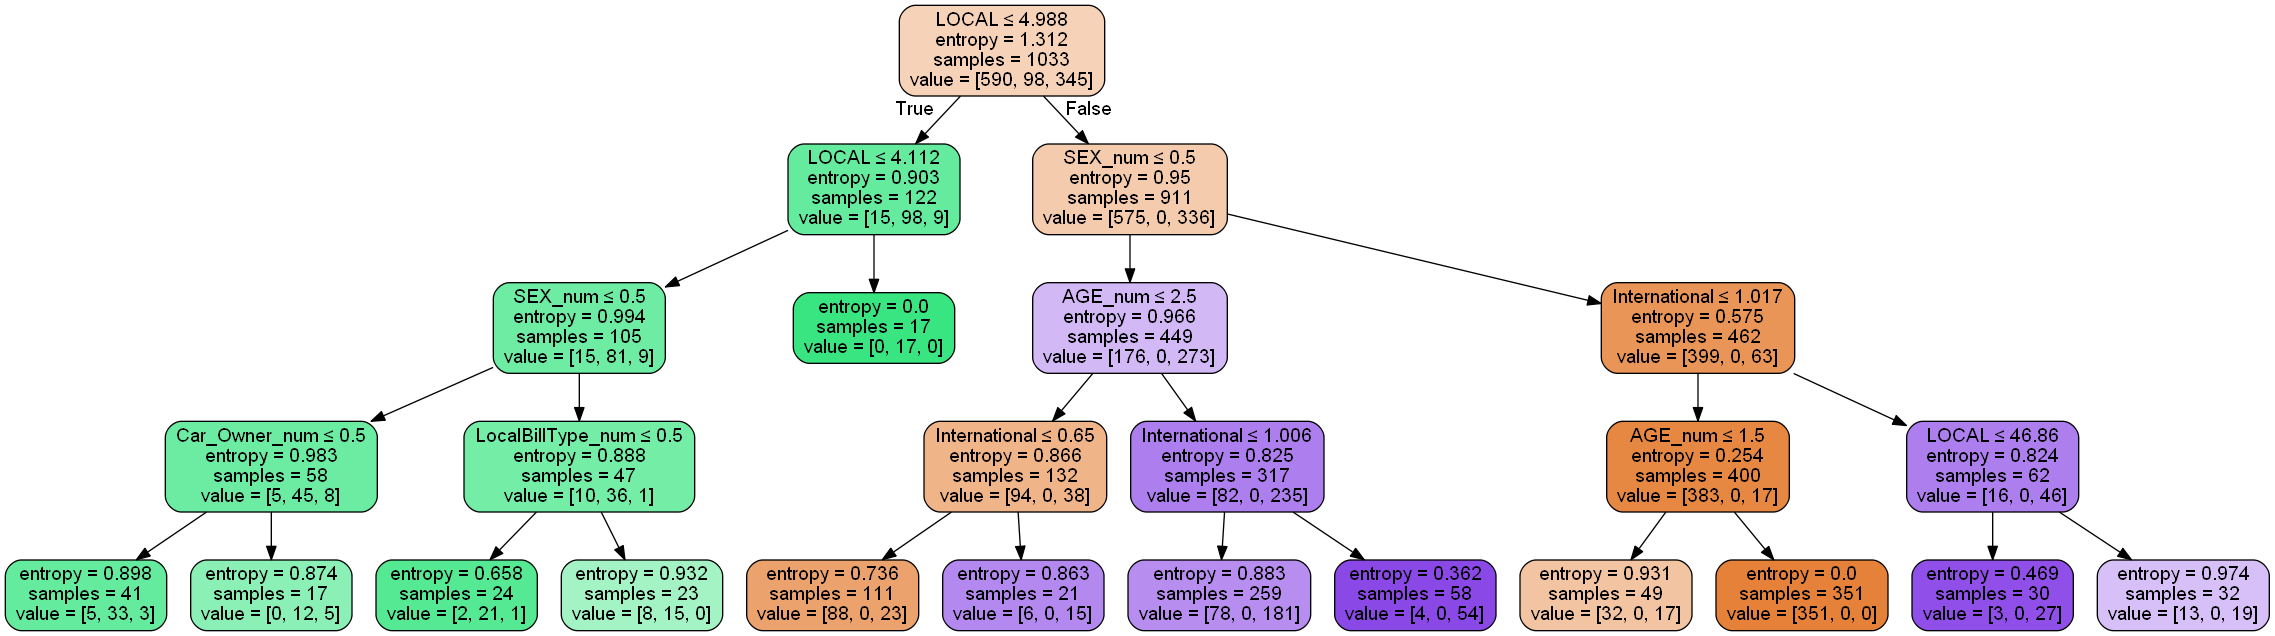

In [184]:
clf = DecisionTreeClassifier(criterion=optimal_config[0], max_depth=optimal_config[1])

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Graph the model
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = input_cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

## Conclusion

Using all the avaialble input variables, the decision tree model could classify churn up to 87.2% accuracy

## Further Improvements

### Re-select Input Variables

##### List of Input Varibles

In [167]:
print(input_cols)

['LONGDIST', 'International', 'LOCAL', 'DROPPED', 'CHILDREN', 'Est_Income', 'PAY_MTHD_num', 'LocalBillType_num', 'LongDistanceBillType_num', 'AGE_num', 'SEX_num', 'STATUS_num', 'Car_Owner_num']


In [168]:
input_cols_new = ['LONGDIST', 'LOCAL', 'Est_Income', 'PAY_MTHD_num', 'AGE_num', 'Car_Owner_num', 'International']

###### Test the Model Again

In [188]:
decision_tree_opt(input_cols_new)

Model Optimal Configuration: 


[0.1, 'gini', 5, 0.73]